# State Estimation:Induction Motor
<span style="color:darkorchid">
    
### Dhruv Ishan Bhardwaj
### Department of Electrical Engineering, IIT Bombay
    
</span>

## Objective
Given a state space and measurement model of a plant, an Induction Motor in our case, evaluate performance of estimators under noisy conditions

## State Space Model

Let $X, Z, Y, W, V$ denote the states, input, measurements, model noise and measurement noise respectively, then state space model is given by

$\frac{dX}{dt}=f(X, Z)+W$

$Y=g(X)+V$

Here, $f, g$ are specific to the system, $W$ ~ $N(0, Q)$ and $V$ ~ $N(0, R)$

### Induction Motor Model
For our system, dimensions of $X, Z, Y, W, V$ are $5, 3, 2, 5, 2$ respectively and they are related as

<span style="color:Purple">

$\frac{dx_1}{dt}= k_1 x_1 + z_1 x_2+k_2 x_3+z_2$

$\frac{dx_2}{dt}= -z_1x_1+k_1x_2+k_2x_4$

$\frac{dx_3}{dt}= k_3 x_1 + k_4x_3+(z_1-x_5)x_4$

$\frac{dx_4}{dt}= k_3 x_2 - (z_1-x_5)x_3+k_4x_4$

$\frac{dx_5}{dt}= k_5 (x_1x_4-x_2x_3)+k_6z_3$

</span>

<span style="color:maroon">

$y_1=k_7x_1+k_8x_3$

$y_2=k_7x_2+k_8x_4$

</span>

Values of constants


| $k_1$  |  $k_2$  |  $k_3$  |  $k_4$  |  $k_5$  |  $k_6$  |  $k_7$  |  $k_8$  |  $z_1$  |  $z_2$  |  $z_3$  |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|-0.186  |0.178    |0.225    |-0.234   |-0.081   |4.643    |   -4.448|    1    |    1    |    1    |    0    |



<span style="color:blue">

$Q=10^{-4}I_{5x5}$ : Model Noise

$R=10^{-2}I_{2x2}$ : Measurement Noise
    
</span>

In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from math import *
import random
random.seed(1)
import scipy.linalg as sp
import scipy.stats

### Python Model

To implement the model in python, we use Range-Kutta 4th order method for the integration step which has local truncation error of order $O$~$(h^5)$, where $h$ is time step. 

A python class "IMotor" with the following attributes x1, x2, x3, x4, x5, k1, k2, k3, k4, k5, k6, k7, k8 denoting the state and constants of the model. The states are initiliased to [0.2, -0.6, -0.4, 0.1, 0.3]

The associated methods of the class are as:

1. y1 : returns measurement $Y_1$
2. y2 : returns measurement $Y_2$
3. dxdt: takes in argument z, a vector denoting inputs and returns a 5x1 array $\frac{dX}{dt}$
4. setState: takes in argument x, 5x1 array and sets the current state to X
5. getState: returns the current state of the system, a 5x1 array
6. update: takes in argument delt, z and a boolean noise. Performs Integration step for one time step using RK-4th order method, with time step delt, input z and adds noise if boolen noise is True
7. update2: same as update except integration is performed with Euler Method
8. linMod: takes in argument Z and returns Jacobian matrices $\frac{\partial f}{\partial X}, \frac{\partial f}{\partial Z}$, which are 5x5 and 5x3 matrices respectively
9. meas: takes in bool noise. If noise is true then adds noise and returns measurements $Y_1, Y_2$ as 2x1 array
10. linMeas: returns a 2x5 matrice $\frac{\partial g}{\partial X}$


In [2]:
class IMotor(object):
    
    def __init__(self):
        
        #States
        self.x1 = 0.2
        self.x2 = -0.6
        self.x3 = -0.4
        self.x4 = 0.1
        self.x5 = 0.3
        
        #Constants
        self.k1 = -0.186
        self.k2 = 0.178
        self.k3 = 0.225
        self.k4 = -0.234
        self.k5 = -0.081
        self.k6 = 4.643
        self.k7 = -4.448
        self.k8 = 1
        
    def y1(self):
        
        #return y1
        return self.k7*self.x1 + self.k8*self.x3
    
    def y2(self):
        
        #return y2
        return self.k7*self.x2 + self.k8*self.x4
    
    def dxdt(self, z):
        
        #compute dx/dt at current X and input z
        z1 = z[0]
        z2 = z[1]
        z3 = z[2]
        
        dx1dt = self.k1*self.x1 + z1*self.x2 + self.k2*self.x3 + z2
        dx2dt = -z1*self.x1 + self.k1*self.x2 + self.k2*self.x4
        dx3dt = self.k3*self.x1 + self.k4*self.x3 + (z1-self.x5)*self.x4
        dx4dt = self.k3*self.x2 - (z1-self.x5)*self.x3 + self.k4*self.x4
        dx5dt = self.k5*(self.x1*self.x4-self.x2*self.x3)+self.k6*z3
        
        #return as numpy array
        return np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])
        
    def setState(self, X):
        
        #set current state to X
        self.x1 = X[0]
        self.x2 = X[1]
        self.x3 = X[2]
        self.x4 = X[3]
        self.x5 = X[4]
    
        
    def getState(self):
        
        #return the states
        return np.array([self.x1, self.x2, self.x3, self.x4, self.x5])
    
    def update(self, delt, z, noise=False):
        #Use RK4 method to integrate
        
        #Initialise
        h = delt
        X0 = self.getState()
        
        #K1 terms
        K1 = h*self.dxdt(z)
        X1 = X0+K1/2
        self.setState(X1)
        
        #K2 terms
        K2 = h*self.dxdt(z)
        X2 = X0+K2/2
        self.setState(X2)
        
        #K3 terms
        K3 = h*self.dxdt(z)
        X3 = X0+K3
        self.setState(X3)
        
        #K4 terms
        K4 = h*self.dxdt(z)
        X = X0 + K1/6 + K2/3 + K3/3 + K4/6
        
        
        if noise == True:
            
            #Add noise
            R = np.identity(5)*1e-4
            X += np.random.multivariate_normal([0, 0, 0, 0, 0], R)
        
        self.setState(X)
        
    def update2(self, delt, z, noise=False):
        
        X = self.getState()
        
        #Euler Interation
        X += delt*self.dxdt(Z)
        
        if noise == True:
            
            #Add noise
            R = np.identity(5)*1e-4
            X += np.random.multivariate_normal([0, 0, 0, 0, 0], R)
        
        self.setState(X)
        
        
    def linMod(self, Z):
        
        Z1 = Z[0]
        Z2 = Z[1]
        Z3 = Z[2]
        
        X = self.getState()
        X1 = X[0]
        X2 = X[1]
        X3 = X[2]
        X4 = X[3]
        X5 = X[4]
        
        #Jacobian df/dX, obtained analytically
        a1 = [self.k1, Z1, self.k2, 0, 0]
        a2 = [-Z1, self.k1, 0, self.k2, 0]
        a3 = [self.k3, 0, self.k4, (Z1-X5), -X4]
        a4 = [0, self.k3, -(Z1-X5), self.k4, X3]
        a5 = [self.k5*X4, -self.k5*X3, -self.k5*X2, self.k5*X1, 0]
        
        #form a matrice
        A = [a1, a2, a3, a4, a5]
        A = np.array(A)
        
        #Jacobian df/dZ, obtained analytically
        c1 = [X2, 1, 0]
        c2 = [-X1, 0, 0]
        c3 = [X4, 0, 0]
        c4 = [-X3, 0, 0]
        c5 = [0, 0, self.k6]
        
        #return as matrice
        D = [c1, c2, c3, c4, c5]
        D = np.array(D)
        
        return A, D
        
    def meas(self, noise=True):
        
        x = self.getState()
        y1 = self.k7*x[0]+self.k8*x[2]
        y2 = self.k7*x[1]+self.k8*x[3]
        Y = np.array([y1, y2])
        
        if noise:
            
            R = np.identity(2)*1e-2
            Y += np.random.multivariate_normal([0, 0], R)
        
        return Y
    
    def linMeas(self):
        
        y1 = [self.k7, 0, self.k8, 0, 0]
        y2 = [0, self.k7, 0, self.k8, 0]
        
        
        C = [y1, y2]
        
        return np.array(C)
        

## Simulation of Motor

Dynamic Input is provided: For first 600 time instants, U=[1, 1, 0], then U=[1.2, 1, 0] for k=600 to k=900, Then U=[0.8, 1, 0] for next 300 instants and U=[1, 1.2, 0] for next 300 instants.

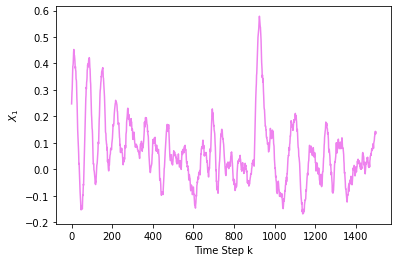

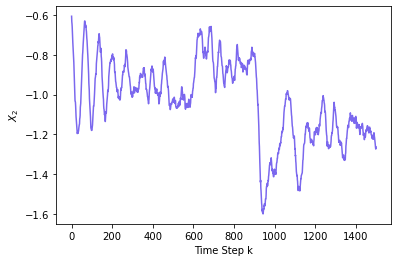

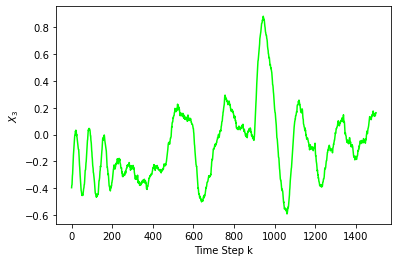

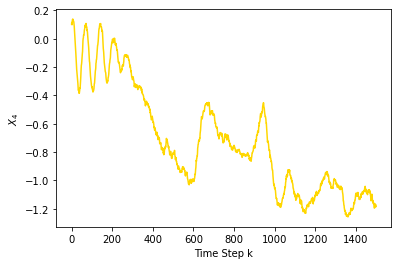

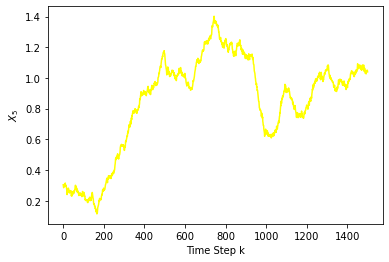

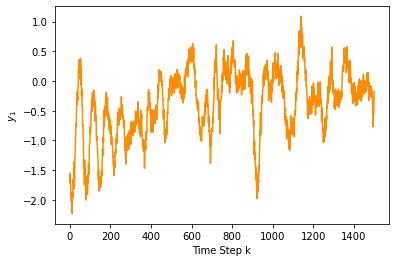

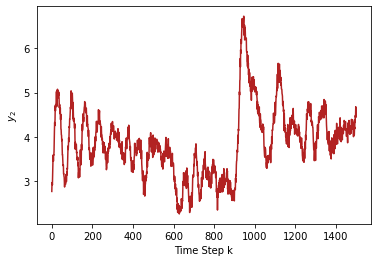

In [3]:
#Simulation Code
a = IMotor()     #Create an instance of induction motor
Xall = []          #Store all states
U1 = []            #Input Y1
U2 = []            #Input Y2
Y1 = []            #Measurement Y1
Y2 = []            #Measurement Y2

#Input is [1, 1, 0]
for i in range(0, 600):
    
    #Store Input
    U1.append(1)
    U2.append(1)
    
    #Perform Update, with noise
    a.update(0.1, [U1[i], U2[i], 0], True)
    
    #Store actual states and measurements with noise
    X = a.getState()
    Xall.append(X)
    y = a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
#Input is [1.2, 1, 0]
for i in range(600, 900):
    
    U1.append(1.2)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X = a.getState()
    Xall.append(X)
    y = a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
#Input is [0.8, 1, 0]
for i in range(900, 1200):
    
    U1.append(0.8)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X = a.getState()
    Xall.append(X)
    y = a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
#Input is [1, 1.2, 0]
for i in range(1200, 1500):
    
    U1.append(1)
    U2.append(1.2)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X = a.getState()
    Xall.append(X)
    y = a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
#Convert to numpy as its easier to manipulate and deal with
Xall = np.array(Xall)

#Plot states

#X1
plt.plot(Xall[:, 0], 'violet')
plt.xlabel('Time Step k')
plt.ylabel('$X_1$')
#plt.savefig('X1s.png')
plt.show()

#X2
plt.plot(Xall[:, 1], 'mediumslateblue')
plt.xlabel('Time Step k')
plt.ylabel('$X_2$')
#plt.savefig('X2s.png')
plt.show()

#X3
plt.plot(Xall[:, 2], 'lime')
plt.xlabel('Time Step k')
plt.ylabel('$X_3$')
#plt.savefig('X3s.png')
plt.show()

#X4
plt.plot(Xall[:, 3], 'gold')
plt.xlabel('Time Step k')
plt.ylabel('$X_4$')
#plt.savefig('X4s.png')
plt.show()

#X5
plt.plot(Xall[:, 4], 'yellow')
plt.xlabel('Time Step k')
plt.ylabel('$X_5$')
#plt.savefig('X5s.png')
plt.show()

#Plot Measurementes

#Y1
plt.plot(Y1, 'darkorange')
plt.xlabel('Time Step k')
plt.ylabel('$y_1$')
plt.savefig('Y1.png')
plt.show()

#Y2
plt.plot(Y2, 'firebrick')
plt.xlabel('Time Step k')
plt.ylabel('$y_2$')
plt.savefig('Y2.png')
plt.show()

### Helpful Functions

Some functions are developed for use in Kalman Filters

1. dxdt: takes in X, z and a default parameter t=0, (to make code more generic t is used though in our case dxdt is dependednt only upon input X and z). Returns $f(X, Z)$ for our model without noise

2. Gx: takes in argument X and returns $Y$ i.e measurement

In [4]:
#dX/dt takes in argument X, Z and returns dX/dt for motor model
def dxdt(X, z, t=0):
    
    k1 = -0.186
    k2 = 0.178
    k3 = 0.225
    k4 = -0.234
    k5 = -0.081
    k6 = 4.643
        
    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    
    x1 = X[0]
    x2 = X[1]
    x3 = X[2]
    x4 = X[3]
    x5 = X[4]
        
    dx1dt = k1*x1 + z1*x2 + k2*x3 + z2
    dx2dt = -z1*x1 + k1*x2 + k2*x4
    dx3dt = k3*x1 + k4*x3 + (z1-x5)*x4
    dx4dt = k3*x2 - (z1-x5)*x3 + k4*x4
    dx5dt = k5*(x1*x4-x2*x3)+k6*z3
        
    return np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])

#Returns measurement on State input X
def Gx(X):
    
    x1 = X[0]
    x2 = X[1]
    x3 = X[2]
    x4 = X[3]
    
    k7 = -4.448
    k8 = 1
     
    y1 = k7*x1 + k8*x3
    y2 = k7*x2 + k8*x4
    
    return np.array([y1, y2])

3. IMlin: takes in arguments x, z and returns jacobian matrices $\frac{\partial f}{\partial X}, \frac{\partial f}{\partial Z}$ and $\frac{\partial \Gamma  W}{\partial W}$ i.e. identity (in our case $\Gamma$ is identity)

10. IMeas: takes in x and returns a 2x5 matrice $\frac{\partial g}{\partial X}$. Though in our case this value is independent of x but that may not always be the case

In [5]:
#Returns Jacobian Matrices, df(X, Z)/dX, df(X, Z)/dZ and dW/dW which is identity in our case
def IMlin(x, z):
    
    k1 = -0.186
    k2 = 0.178
    k3 = 0.225
    k4 = -0.23
    k5 = -0.081
    k6 = 4.643
    
    dx1 = np.array([k1, z[0], k2, 0, 0])
    dx2 = np.array([-z[0], k1, 0, k2, 0])
    dx3 = np.array([k3, 0, k4, z[0]-x[4], -x[3]])
    dx4 = np.array([0, k3, -(z[0]-x[4]), k4, x[2]])
    dx5 = np.array([k5*x[3], -k5*x[2], -k5*x[1], k5*x[0], 0])
    
    A = np.array([dx1, dx2, dx3, dx4, dx5])
    
    dz1 = np.array([x[1], 1, 0])
    dz2 = np.array([-x[0], 0, 0])
    dz3 = np.array([x[3], 0, 0])
    dz4 = np.array([-x[2], 0, 0])
    dz5 = np.array([0, 0, k6])
    
    B = [dz1, dz2, dz3, dz4, dz5]
    B = np.array(B)
    
    C = np.identity(5)
    
    return A, B, C

#Returns the measurement Jacobian i.e dG(X)/dx, actually in our case its constant independent of x
def IMeas(x):
    
    k7 = -4.448
    k8 = 1
    
    y1 = np.array([k7, 0, k8, 0, 0])
    y2 = np.array([0, k7, 0, k8, 0])
    
    C = [y1, y2]
    
    return np.array(C)
    

5. genSigma: takes in two arguments X and P and computes the sigma points and returns them.

6. Fx: takes in arguments X, dt and Z. ie current state X, time step and input. It performs integration with RK-4 method and returns new $X(t+dt)$ which is very close to $X(t)+\int_t^{t+dt}f(X(t), Z)$

7. festimate: takes in Xs (the sigma points as matrice), dt (time step) and input Z and performs the above integration function Fx on each of the sigma points to generate new propagated sigma points.

8. xPx: takes in Xs, the sigma points matrix and computes the weighted statistics (mean and Variance Matrice) of the points.

9. gestimate: takes in Xs, the sigma points as matrice and performs the function Gx on each of them. ie. generates measurements and returns them as matrice

10. yPy: takes in Ys, the sigma points measurement matric and computes its weighted statistics (mean and Variance Matrice)

11. xPy: takes in two matrices X, Y-the sigma points matric and sigma points measurements mattice and computes the weighted Co-variance matrice

12. getWeights: takes in M, an integer denoting dimension of the state vector and returns output a weights array.

In [6]:
def genSigma(X, P):
    
    #Given X, P generat
    M=len(X)
    
    if M>=3:
        K=1
    else:
        K=3-M
        
    p=sqrt(M+K)
    x=np.zeros([M, 2*M+1])
    x[:, 0]=X
    for i in range(0, M):
        a=P[i]
        for j in range(0, len(a)):
            if a[j]<0:
                a[j]=0
        x[:, i+1]=X+p*np.sqrt(a)
        x[:, i+M+1]=X-p*np.sqrt(a)
        
    return np.array(x)

def Fx(X, dt, Z):
    
    a=IMotor()
    a.setState(X)
    a.update(dt, Z)
    return a.getState()


def festimate(Xs, t, Z):
    
    Xn=np.zeros([5, 11])
    for i in range(0, 11):
        Xn[:, i]=Fx(Xs[:, i], t, Z)
    return Xn

def xPx(X):
    
    W=getWeights(5)
    xmean=np.zeros(5)
    for i in range(0, 11):
        xmean+=W[i]*X[:, i]
    P=np.zeros([5, 5])

    for i in range(0, 11):
        e=X[:, i]-xmean
        P+=W[i]*np.outer(e, e)
        
    xmean=np.around(xmean, decimals=12)
    P=np.around(P, decimals=12)

    return xmean, P

def gestimate(Xs):
    Ys=np.zeros([2, 11])
    for i in range(11):
        Ys[:, i]=Gx(Xs[:, i])
    return Ys

def yPy(Y):
    
    W=getWeights(5) 
    ymean=np.zeros(2)
    for i in range(11):
        ymean+=W[i]*Y[:, i]

    P=np.zeros([2, 2])
    for i in range(0, 11):
        e=Y[:, i]-ymean
        P+=W[i]*np.outer(e, e)
   
    ymean=np.around(ymean, decimals=12)
    P=np.around(P, decimals=12)
    #P+=R
    return ymean, P

def xPy(X, Y):
    
    W=getWeights(5)
    
    xmean=np.zeros(5)
    ymean=np.zeros(2)
    for i in range(0, 11):
        xmean+=W[i]*X[:, i]
        ymean+=W[i]*Y[:, i]
    

    C=np.zeros([5, 2])
    for i in range(11):
        ex=X[:, i]-xmean
        ey=Y[:, i]-ymean
        C+=W[i]*np.outer(ex, ey)
    
    C=np.around(C, decimals=12)
    return C

def getWeights(M):
    
    if M>=3:
        K=0.95   #This parameter can be tweaked according to model
    else:
        K=3-M
        
    W=np.ones(2*M+1)
    W=W*(1/2/(K+M))
    W[0]=K/(K+M)
    
    return W

## Kalman Filter
First we initialise a dummy motor model i.e. using IMotor and reach a steady state by running it for 500 instants with input [1, 1, 0]. Then we use linMod function to get Jacobian matrices with which we linearise the model about this steady state. Thereafter using the measurements we estimate the states and store them for plotting. We also compute Estimation error, innovation, spectral radii of predicted and updated variance matrices and also normalised mean square error


In [7]:
#A dummy motor named S
S=IMotor()

for i in range(500):
    S.update(0.1, [1, 1, 0]) # Running the motor, actually quite literally here :)

Xsteady=S.getState()         #Obtain the steady state
A, B=a.linMod([1, 1, 0])     #Jacobian matrices


Phi=np.identity(5)+A*0.1     #Phi 
Tau=0.1*B                    #delta T times B
C=IMeas(0)                   #dg/dx

Qd=np.identity(5)*1e-4       #variance matrice of model noise
R=np.identity(2)*1e-2        #variance matrice of measurement noise
xest=S.getState()            #Initial estimate, taken as steady state value
Pest=np.identity(5)          #Initial estimate of co-varaiunce

Xstore=[]  #Store all the estimated states
Ey=[]      #Innovation
Ex=[]      #Actual Error
Bk=[]      #Bk     
Rp=[]      #Spectral Radii-Predicted
Ru=[]      #Spectral Radii-Updated


E=[]  
T=0.1 #Time Step

for i in range(0, 1500):
    
    #Model Propagation
    xest+=T*dxdt(xest, [U1[i], U2[i], 0])
    Pest=np.linalg.multi_dot([Phi, Pest, np.transpose(Phi)])+Qd
    
    #Spectral Radius of predicted variance
    Gara, dump=np.linalg.eig(Pest)
    Rp.append(max(Gara))
    
    #Compute Kalman Gain Matrix
    t1=np.linalg.multi_dot([C, Pest, np.transpose(C)])+R
    t1=np.linalg.inv(t1)
    L=np.linalg.multi_dot([Pest, np.transpose(C), t1])
    
    #Compute Innovation
    Y=np.array([Y1[i], Y2[i]])
    e=Y-np.dot(C, xest)
    Ey.append(e)
    
    #Update Estimates
    xest=xest+np.dot(L, e)
    t1=np.identity(5)-np.dot(L, C)
    Pest=np.dot(t1, Pest)
    
    #Spectral Radius of Updated Variance
    Gara, dump=np.linalg.eig(Pest)
    Ru.append(max(Gara))
    
    #Storing estimated results
    Xstore.append(xest)
    ex=Xall[i]-xest
    Ex.append(ex)
    Pinverse=sp.inv(Pest)
    
    #Normalised Mean Square Error
    bk=np.dot(ex, np.dot(Pinverse, ex))
    Bk.append(bk)

In [8]:
#KF Data Storings
Xstorekf=np.array(Xstore)
Exkf=np.array(Ex)
Eykf=np.array(Ey)
Rpkf=np.array(Rp)
Rukf=np.array(Ru)
Bkkf=np.array(Bk)

## Extended Kalman Filter

Instead of linearising about steady point, we linearise about current state estimate

In [13]:
x=np.array([0.2, -0.6, -0.4, 0.1, 0.3])   #initial estimate of state
P=np.identity(5)                          #initial estimate of variance
Qd=np.identity(5)*1e-4                     #model uncertainity variance
R=np.identity(2)*1e-2                      #measurement uncertainity variance
T=0.1      #Time Step

Xstore=[]  #All estimated data
Ey=[]      #Innovation
Ex=[]      #Actual Error
Bk=[]      #Bk     
Rp=[]      #Spectral Radii-Predicted
Ru=[]      #Spectral Radii-Updated


for i in range(0, 1500):
    
    Z=[U1[i], U2[i], 0]
    
    #Form the linear model
    A, dump, B=IMlin(x0, Z)
    Phi=sp.expm(A*T)
    Tau=np.linalg.multi_dot([Phi-np.identity(5), np.linalg.inv(A), B])
    
    #Prediction
    x+=T*dxdt(x, Z)
    P=np.linalg.multi_dot([Phi, P, np.transpose(Phi)])+np.linalg.multi_dot([Tau, Qd, np.transpose(Tau)])
    
    #Spectral Radius of Predicted Variance
    Gara, dump=np.linalg.eig(P)
    Rp.append(max(Gara))
    
    #Kalman Gain Matrix
    C=IMeas(x)
    t1=np.linalg.multi_dot([C, P, np.transpose(C)])+R
    t2=np.linalg.inv(t1)
    L=np.linalg.multi_dot([P, np.transpose(C), t2])
    
    #Update Step
    Y=[Y1[i], Y2[i]]
    e=np.array(Y)-Gx(x)
    Ey.append(e)
    x+=np.dot(L, e)
    P=np.dot(np.identity(5)-np.dot(L, C), P)
    
    #Store data for plotting
    Xstore.append(list(x))
    ex=Xall[i]-x
    Ex.append(ex)
    
    #Normalised Mean Square Error
    Pinverse=sp.inv(P)
    bk=np.dot(ex, np.dot(Pinverse, ex))
    Bk.append(bk)
    
    #Spectral Radius of Updated Variance
    Gara, dump=np.linalg.eig(P)
    Ru.append(max(Gara))

In [14]:
#Store EKF Values
Xstoreekf = np.array(Xstore)
Exekf = np.array(Ex)
Eyekf = np.array(Ey)
Rpekf = np.array(Rp)
Ruekf = np.array(Ru)
Bkekf = np.array(Bk)

## Unscented Kalman Filter

We use the 'helpful functions' in our algorithm. First generate sigma points based on current state and variance estimate, then propagate the points through the model, then compute new statistics i.e. mean and new variance (predicted variance) and compute new sigma points. Obtain measurements from measurement model to generate sigma points of measurements. Then compute the new statistics from sigma measurements to get Kalman Gain and innovation

In [15]:
#Same symbols with usual meaning
X = np.zeros(5)
P = np.identity(5)
Q = np.identity(5)*1e-4
R = np.identity(2)*1e-2

Xstore = []  #All estimated data
Ey = []      #Innovation
Ex = []      #Actual Error
Bk = []      #Bk     
Rp = []      #Spectral Radii-Predicted
Ru = []      #Spectral Radii-Updated

for i in range(0, len(U1)):
    
    #Obtain the input for this time step and sigma points from current estimated X and P
    Z = np.array([U1[i], U2[i], 0])
    Xs = genSigma(X, P)
  
    #Propagate the sigma points throught the model and obtain stats
    Xn = festimate(Xs, T, Z)
    X, P = xPx(Xn)
    
    #Obtain spectral Radius of Predicted variance
    Gara, dump = np.linalg.eig(P)
    Rp.append(max(Gara))
    
    #generate new sigma points from propagated model
    Xin = genSigma(X, P)
    
    #Generate measurement sigma points and their stats
    Ys = gestimate(Xin)
    Y, Py = yPy(Ys)
    Py += R
    
    #Compute Kalman Gain
    c = xPy(Xin, Ys)
    Pyi = sp.inv(Py)
    L = np.dot(c, Pyi)
    y = np.array([Y1[i], Y2[i]])
    e =y-Y

    Ey.append(e)
    
    #Update Step
    X = X+np.dot(L, e)
    P = P-np.linalg.multi_dot([L, Py, np.transpose(L)])+Q
    Xstore.append(X)
    
    ex = Xall[i]-X
    Ex.append(ex)
    
    #Commpute Normalised Mean Square Error
    Pinverse = sp.inv(P)
    bk = abs(np.dot(np.transpose(ex), np.dot(Pinverse, ex)))
    Bk.append(bk)
    
    #Compute spectral radius of updated variance
    Gara, dump = np.linalg.eig(P)
    Ru.append(max(Gara))

In [16]:
#Store UKF Values
Xstoreukf = np.array(Xstore)
Exukf = np.array(Ex)
Eyukf = np.array(Ey)
Rpukf = np.array(Rp)
Ruukf = np.array(Ru)
Bkukf = np.array(Bk)

## Plot Results

First Plot all the States and their estimates from all three filters

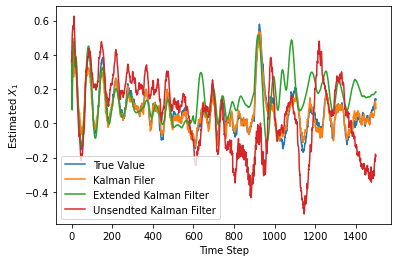

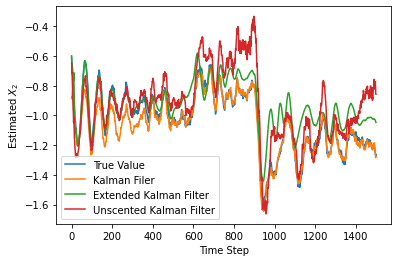

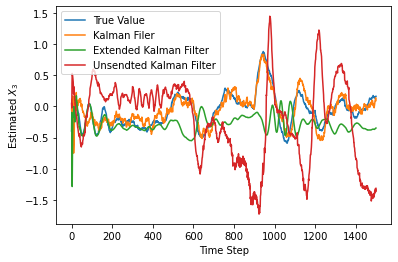

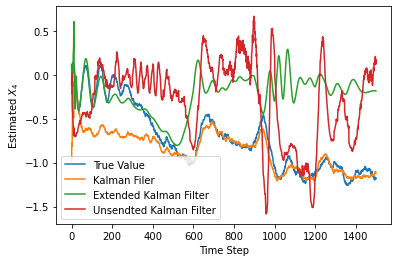

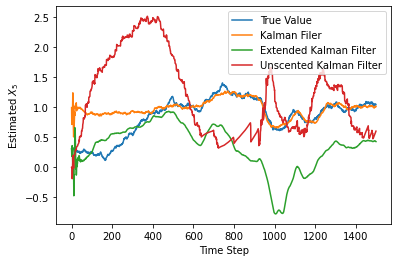

In [17]:
plt.plot(Xall[:, 0])
plt.plot(Xstorekf[:, 0])
plt.plot(Xstoreekf[:, 0])
plt.plot(Xstoreukf[:, 0])
plt.ylabel('Estimated $X_1$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('x1.png')
plt.show()

plt.plot(Xall[:, 1])
plt.plot(Xstorekf[:, 1])
plt.plot(Xstoreekf[:, 1])
plt.plot(Xstoreukf[:, 1])
plt.ylabel('Estimated $X_2$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unscented Kalman Filter'])
plt.savefig('x2.png')
plt.show()

plt.plot(Xall[:, 2])
plt.plot(Xstorekf[:, 2])
plt.plot(Xstoreekf[:, 2])
plt.plot(Xstoreukf[:, 2])
plt.ylabel('Estimated $X_3$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('x3.png')
plt.show()


plt.plot(Xall[:, 3])
plt.plot(Xstorekf[:, 3])
plt.plot(Xstoreekf[:, 3])
plt.plot(Xstoreukf[:, 3])
plt.ylabel('Estimated $X_4$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('x4.png')
plt.show()


plt.plot(Xall[:, 4])
plt.plot(Xstorekf[:, 4])
plt.plot(Xstoreekf[:, 4])
plt.plot(Xstoreukf[:, 4])
plt.ylabel('Estimated $X_5$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unscented Kalman Filter'])
plt.savefig('x5.png')
plt.show()

Now, Plot the innovations i.e. Measurement vs Predicted Measurement

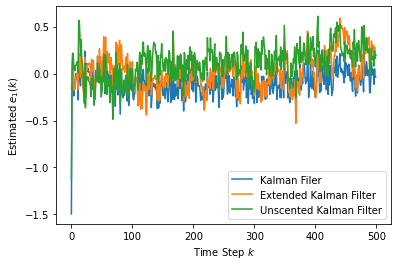

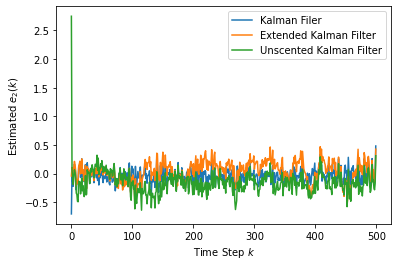

In [18]:
plt.plot(Eykf[:500, 0])
plt.plot(Eyekf[:500, 0])
plt.plot(Eyukf[:500, 0])
plt.ylabel('Estimated $e_1(k)$')
plt.xlabel('Time Step $k$')
plt.legend(['Kalman Filer', 'Extended Kalman Filter', 'Unscented Kalman Filter'])
plt.savefig('e1y.png')
plt.show()


plt.plot(Eykf[:500, 1])
plt.plot(Eyekf[:500, 1])
plt.plot(Eyukf[:500, 1])
plt.ylabel('Estimated $e_2(k)$')
plt.xlabel('Time Step $k$')
plt.legend(['Kalman Filer', 'Extended Kalman Filter', 'Unscented Kalman Filter'])
plt.savefig('e2y.png')
plt.show()

Plot the Spectral Radii for all the three filters

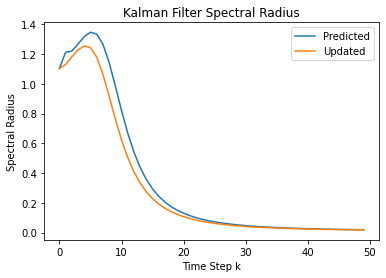

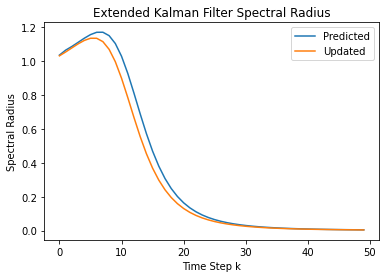

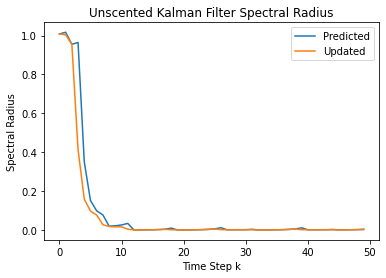

In [19]:
plt.plot(Rpkf[:50])
plt.plot(Rukf[:50])
plt.xlabel('Time Step k')
plt.ylabel('Spectral Radius')
plt.legend(['Predicted', 'Updated'])
plt.title('Kalman Filter Spectral Radius')
plt.savefig('srkf.png')
plt.show()

plt.plot(Rpekf[:50])
plt.plot(Ruekf[:50])
plt.xlabel('Time Step k')
plt.ylabel('Spectral Radius')
plt.legend(['Predicted', 'Updated'])
plt.title('Extended Kalman Filter Spectral Radius')
plt.savefig('srekf.png')
plt.show()

plt.plot(Rpukf[:50])
plt.plot(Ruukf[:50])
plt.xlabel('Time Step k')
plt.ylabel('Spectral Radius')
plt.legend(['Predicted', 'Updated'])
plt.title('Unscented Kalman Filter Spectral Radius')
plt.savefig('srukf.png')
plt.show()

Plot the Estimation Errors of states from time instant 500 onwards, along with their $\pm 3 \sigma$ (std deviations)

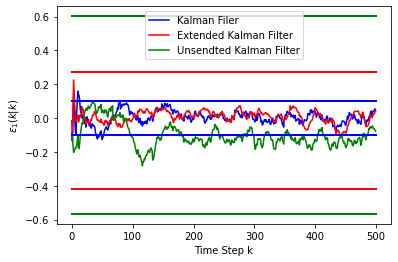

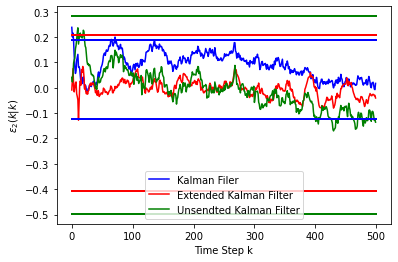

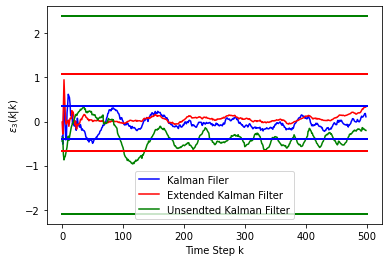

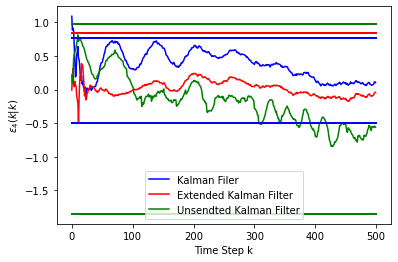

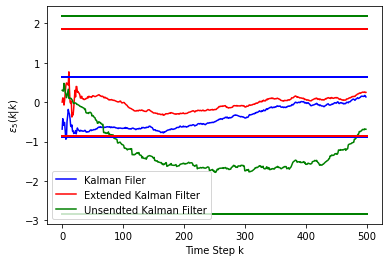

In [20]:
n=500
plt.plot(Exkf[:n, 0], 'b')
plt.plot(Exekf[:n, 0], 'r')
plt.plot(Exukf[:n, 0], 'g')
dkf=np.std(Exkf[:, 0])
mkf=np.average(Exkf[:, 0])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 0])
mkf=np.average(Exekf[:, 0])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 0])
mkf=np.average(Exukf[:, 0])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_1(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex1.png')
plt.show()

plt.plot(Exkf[:n, 1], 'b')
plt.plot(Exekf[:n, 1], 'r')
plt.plot(Exukf[:n, 1], 'g')
dkf=np.std(Exkf[:, 1])
mkf=np.average(Exkf[:, 1])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 1])
mkf=np.average(Exekf[:, 1])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 1])
mkf=np.average(Exukf[:, 1])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_2(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex2.png')
plt.show()

plt.plot(Exkf[:n, 2], 'b')
plt.plot(Exekf[:n, 2], 'r')
plt.plot(Exukf[:n, 2], 'g')
dkf=np.std(Exkf[:, 2])
mkf=np.average(Exkf[:, 2])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 2])
mkf=np.average(Exekf[:, 2])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 2])
mkf=np.average(Exukf[:, 2])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_3(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex3.png')
plt.show()

plt.plot(Exkf[:n, 3], 'b')
plt.plot(Exekf[:n, 3], 'r')
plt.plot(Exukf[:n, 3], 'g')
dkf=np.std(Exkf[:, 3])
mkf=np.average(Exkf[:, 3])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 3])
mkf=np.average(Exekf[:, 3])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 3])
mkf=np.average(Exukf[:, 3])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_4(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex4.png')
plt.show()

plt.plot(Exkf[:n, 4], 'b')
plt.plot(Exekf[:n, 4], 'r')
plt.plot(Exukf[:n, 4], 'g')
dkf=np.std(Exkf[:, 4])
mkf=np.average(Exkf[:, 4])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 4])
mkf=np.average(Exekf[:, 4])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 4])
mkf=np.average(Exukf[:, 4])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_5(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex5.png')
plt.show()

Print the average Innovation errors and Standard Deviations

In [21]:
print('Average Ey1 KF:'+str(np.average(Eykf[:, 0])))
print('Average Ey2 KF:'+str(np.average(Eykf[:, 1])))
print('Average Ey1 EKF:'+str(np.average(Eyekf[:, 0])))
print('Average Ey2 EKF:'+str(np.average(Eyekf[:, 1])))
print('Average Ey1 UKF:'+str(np.average(Eyukf[:, 0])))
print('Average Ey2 UKF:'+str(np.average(Eyukf[:, 1])))
print()
print('Std Ey1 KF:'+str(np.std(Eykf[:, 0])))
print('Std Ey2 KF:'+str(np.std(Eykf[:, 1])))
print('Std Ey1 EKF:'+str(np.std(Eyekf[:, 0])))
print('Std Ey2 EKF:'+str(np.std(Eyekf[:, 1])))
print('Std Ey1 UKF:'+str(np.std(Eyukf[:, 0])))
print('Std Ey2 UKF:'+str(np.std(Eyukf[:, 1])))

Average Ey1 KF:-0.035271897358546224
Average Ey2 KF:-0.013317425714292189
Average Ey1 EKF:0.5533978685905756
Average Ey2 EKF:-0.06354146599142084
Average Ey1 UKF:0.10489058134105118
Average Ey2 UKF:0.06343015556106883

Std Ey1 KF:0.13900420467864621
Std Ey2 KF:0.12811327492630387
Std Ey1 EKF:0.5008793714408776
Std Ey2 EKF:0.35860006997609667
Std Ey1 UKF:0.26132233015379414
Std Ey2 UKF:0.36214012090225445


Print the RMS eestimation errors and standard deviations

In [22]:
def RMSp(E):
    s=0
    xm=np.average(X)
    for i in E:
        s+=i**2
    s=s/len(E)
    return sqrt(s)

In [23]:
print('For KF')
print('For X1 '+str(RMSp(Exkf[:, 0])))
print('For X2 '+str(RMSp(Exkf[:, 1])))
print('For X3 '+str(RMSp(Exkf[:, 2])))
print('For X4 '+str(RMSp(Exkf[:, 3])))
print('For X5 '+str(RMSp(Exkf[:, 4])))
print()
print('For EKF')
print('For X1 '+str(RMSp(Exekf[:, 0])))
print('For X2 '+str(RMSp(Exekf[:, 1])))
print('For X3 '+str(RMSp(Exekf[:, 2])))
print('For X4 '+str(RMSp(Exekf[:, 3])))
print('For X5 '+str(RMSp(Exekf[:, 4])))
print()
print('For UKF')
print('For X1 '+str(RMSp(Exukf[:, 0])))
print('For X2 '+str(RMSp(Exukf[:, 1])))
print('For X3 '+str(RMSp(Exukf[:, 2])))
print('For X4 '+str(RMSp(Exukf[:, 3])))
print('For X5 '+str(RMSp(Exukf[:, 4])))

For KF
For X1 0.03387781946587956
For X2 0.061678080617824434
For X3 0.12716140781081575
For X4 0.25043840988003313
For X5 0.28464921938573695

For EKF
For X1 0.13616446829154064
For X2 0.1424594494405143
For X3 0.3587720656294492
For X4 0.6748841281715501
For X5 0.6819541347473094

For UKF
For X1 0.1956368719774114
For X2 0.16881632859530563
For X3 0.7612503937779039
For X4 0.6433361955712964
For X5 0.8985495191193578


Lets see the significance level of filters

First we have the normalised estimation error squared for each filter stored as 'Bkkf', 'Bkekf' and 'Bkukf' for Kalman, EK and UK filters repectively. Let $\zeta_1, \zeta_2$ be threshold derived from chi-aquared density with n degrees of freedom (n=5) and $\alpha=0.05$ (the significance level)

In [24]:
c1 = scipy.stats.chi2.ppf(0.05, df=5)
c2 = scipy.stats.chi2.ppf(0.95, df=5)

A function PA that takes in Bk an array and computes the fraction of values in Bk within the range $[\zeta_1, \zeta_2]$

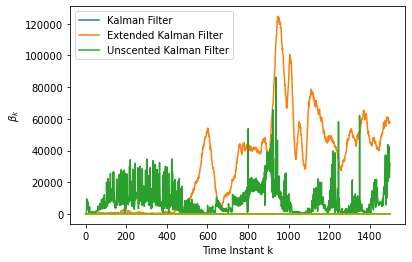

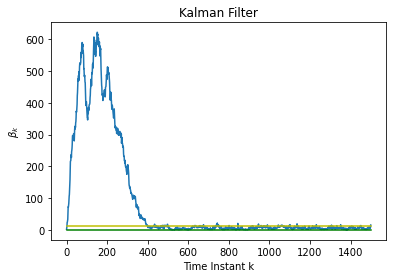

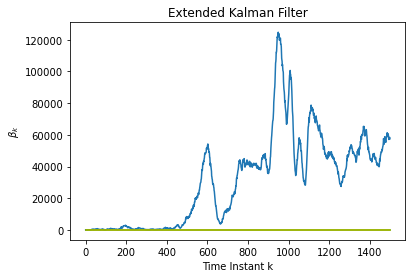

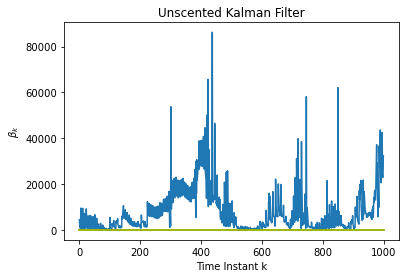

In [25]:
def PA(Bk):  
    
    n = 0
    
    for i in Bk:
        
        if c1>=i or i>=c2:
            
            n+=1
    
    return n/len(Bk)

plt.plot(Bkkf)
plt.plot(Bkekf)
plt.plot(Bkukf)
plt.plot([0, 1500], [c1, c1], '-g')
plt.plot([0, 1500], [c2, c2], '-y')
plt.xlabel('Time Instant k')
plt.ylabel('$\\beta_k$')
plt.legend(['Kalman Filter', 'Extended Kalman Filter', 'Unscented Kalman Filter'])
plt.savefig('Allbk.png')
plt.show()

plt.plot(Bkkf)
plt.xlabel('Time Instant k')
plt.ylabel('$\\beta_k$')
plt.title('Kalman Filter')
plt.plot([0, 1500], [c1, c1], '-g')
plt.plot([0, 1500], [c2, c2], '-y')
plt.savefig('kfbk.png')
plt.show()

plt.plot(Bkekf)
plt.xlabel('Time Instant k')
plt.ylabel('$\\beta_k$')
plt.title('Extended Kalman Filter')
plt.plot([0, 1500], [c1, c1], '-g')
plt.plot([0, 1500], [c2, c2], '-y')
plt.savefig('ekfbk.png')
plt.show()

plt.plot(Bkukf[500:])
plt.xlabel('Time Instant k')
plt.ylabel('$\\beta_k$')
plt.title('Unscented Kalman Filter')
plt.plot([0, 1000], [c1, c1], '-g')
plt.plot([0, 1000], [c2, c2], '-y')
plt.savefig('ukfbk.png')
plt.show()

In [26]:
print('For KF, fraction not in limits is '+str(PA(Bkkf)))
print('For EKF, fraction not in limits is '+str(PA(Bkekf)))
print('For UKF, fraction not in limits is '+str(PA(Bkukf)))

For KF, fraction not in limits is 0.38466666666666666
For EKF, fraction not in limits is 0.994
For UKF, fraction not in limits is 0.9993333333333333


In [27]:
print('For KF in steady state, fraction not in limits is '+str(PA(Bkkf[500:])))
print('For EKF in steady state, fraction not in limits is '+str(PA(Bkekf[500:])))
print('For UKF in steady state, fraction not in limits is '+str(PA(Bkukf[500:])))

For KF in steady state, fraction not in limits is 0.149
For EKF in steady state, fraction not in limits is 1.0
For UKF in steady state, fraction not in limits is 1.0
